# Dataset distillation

Dataset distillation is a technique in machine learning that aims to “compress” a large training dataset into a much smaller synthetic dataset while preserving as much of the original information as possible. The goal is that when a model is trained on this distilled (or synthetic) dataset, it achieves performance close to that of a model trained on the full dataset. This can be especially useful when storage, computation, or training time are at a premium.

---

## 1. Motivation and Overview

Traditional training datasets can be very large, but often there is significant redundancy in the data. **Dataset distillation** seeks to create a small set of synthetic examples $ \mathcal{S} $ that capture the essential features of the full dataset $ \mathcal{D} $. When a neural network is trained on $ \mathcal{S} $, its learned parameters should ideally perform nearly as well as if it had been trained on $ \mathcal{D} $.

---

## 2. The Meta-Learning Formulation

The problem of dataset distillation can be formulated as a bi-level optimization problem. The inner loop involves training a model on the synthetic dataset, while the outer loop optimizes the synthetic data so that the trained model performs well on a validation set or even on the full dataset. A common formulation is:

$$
\mathcal{S}^* = \arg\min_{\mathcal{S}} \, \mathbb{E}_{\theta_0 \sim P(\theta_0)} \Big[ \mathcal{L}_{\text{val}} \big( \theta_T(\mathcal{S}) \big) \Big]
$$

Here:
- $ \theta_0 $ is the initial parameter of the network, drawn from some distribution $ P(\theta_0) $.
- $ \theta_T(\mathcal{S}) $ are the network parameters after $ T $ training steps on the distilled dataset $ \mathcal{S} $.
- $ \mathcal{L}_{\text{val}} $ is the loss computed on a validation set (or on the full dataset $ \mathcal{D} $).

The inner optimization (training on $ \mathcal{S} $) is typically performed using gradient descent:

$$
\theta_{t+1} = \theta_t - \eta \, \nabla_{\theta_t} \mathcal{L}(\mathcal{S}, \theta_t)
$$

where $ \eta $ is the learning rate.

---

## 3. Gradient Matching Objective

One popular method for dataset distillation is based on **gradient matching**. The idea is that the gradients computed from the synthetic dataset should closely match the gradients computed from the original dataset. Consider the following definitions:

- For the distilled dataset $ \mathcal{S} = \{ (\tilde{x}_i, \tilde{y}_i) \}_{i=1}^{M} $ (with $ M $ samples) and the original dataset $ \mathcal{D} = \{ (x_j, y_j) \}_{j=1}^{N} $ (with $ N $ samples), the gradients are given by:

  $$
  g(\theta, \mathcal{S}) = \frac{1}{M} \sum_{i=1}^{M} \nabla_{\theta} \ell(\theta; \tilde{x}_i, \tilde{y}_i)
  $$
  
  $$
  g(\theta, \mathcal{D}) = \frac{1}{N} \sum_{j=1}^{N} \nabla_{\theta} \ell(\theta; x_j, y_j)
  $$

- The **gradient matching loss** can be defined as the squared distance between these two gradients:

  $$
  \mathcal{L}_{\text{match}} = \left\| g(\theta, \mathcal{S}) - g(\theta, \mathcal{D}) \right\|^2
  $$

By minimizing $ \mathcal{L}_{\text{match}} $, the distilled dataset is tuned so that a network trained on $ \mathcal{S} $ receives gradient updates that mimic those it would receive when trained on $ \mathcal{D} $.

---

## 4. Bi-Level Optimization and Differentiation Through Training

The overall optimization process for dataset distillation involves differentiating through the training procedure. Specifically, one must compute the gradient of the outer loss $ \mathcal{L}_{\text{val}} $ with respect to the synthetic data $ \mathcal{S} $. This requires backpropagating through the $ T $ training steps. In other words, we have:

$$
\frac{\partial \mathcal{L}_{\text{val}}}{\partial \mathcal{S}} = \frac{\partial \mathcal{L}_{\text{val}} \big( \theta_T(\mathcal{S}) \big)}{\partial \theta_T} \cdot \frac{\partial \theta_T(\mathcal{S})}{\partial \mathcal{S}}
$$

This process is computationally challenging because it involves differentiating through many iterations of gradient descent. Researchers often use techniques from meta-learning to efficiently approximate these gradients.

---

You can laso “distill” a dataset without training a model from scratch by leveraging a pre-trained network like ResNet to extract meaningful feature representations. This approach doesn’t optimize synthetic data via an inner training loop (as in traditional dataset distillation) but instead uses the network’s learned features to select representative samples or construct synthetic examples in the feature space.

Below are two common strategies:

---

### 1. Coreset Selection via Feature Extraction

**Idea:**  
Use a pre-trained ResNet to transform each data point $ x_i $ into a feature vector $ z_i = f(x_i) $. These features encapsulate the semantic information learned by the network.

**Method:**  
Select a subset $ \mathcal{S} $ from your full dataset $ \mathcal{D} $ that best represents the diversity of the data. One way to formalize this is through the coreset selection objective:

$$
\min_{\mathcal{S} \subset \mathcal{D}, \, |\mathcal{S}| = M} \sum_{i=1}^{N} \min_{j \in \mathcal{S}} \| z_i - z_j \|
$$

Here:
- $ N $ is the total number of samples.
- $ M $ is the number of samples you want in your distilled dataset.
- The goal is to choose $ M $ representative feature vectors such that every point in the dataset is close to at least one selected point.

This way, you effectively “compress” the dataset by keeping only the most representative examples without re-training a model.

---

### 2. Clustering in Feature Space

**Idea:**  
Cluster the feature representations extracted from the pre-trained model to identify groups of similar data points.

**Method:**  
Perform k-means clustering on the set of feature vectors $ \{ z_i \} $. The objective function for k-means is:

$$
\min_{c_1, \dots, c_K} \sum_{i=1}^{N} \min_{k=1,\dots,K} \| z_i - c_k \|^2
$$

- $ c_k $ are the cluster centers.
- $ K $ (the number of clusters) is chosen based on the desired level of compression.

Once clusters are formed, you can either:
- **Select representative samples:** Choose the data point closest to each cluster center.
- **Synthesize new examples:** Use the cluster centers directly (though these are in feature space) and then possibly invert them to the input space with additional techniques (like using a generator network).

This approach ensures that the distilled dataset captures the main modes of variation in the full dataset.

---

##  Practical Considerations and Applications

- **Efficiency:** With a distilled dataset, training time and storage requirements can be drastically reduced.
- **Generalization:** A well-distilled dataset can help a model generalize better by focusing on the most informative aspects of the data.
- **Robustness:** In some cases, the synthetic data might capture invariant features that are robust to variations present in the full dataset.

Dataset distillation has potential applications in scenarios where data transmission is limited (e.g., on-device learning) or where rapid training is required (e.g., continual learning scenarios).

---

## Summary

Dataset distillation involves creating a small, synthetic dataset $ \mathcal{S} $ such that training on $ \mathcal{S} $ yields performance similar to training on the full dataset $ \mathcal{D} $. This is often formulated as a bi-level optimization problem where the inner loop involves standard gradient descent training and the outer loop optimizes $ \mathcal{S} $ based on a validation loss. A common approach is to use gradient matching:

$$
\mathcal{L}_{\text{match}} = \left\| \frac{1}{M} \sum_{i=1}^{M} \nabla_{\theta} \ell(\theta; \tilde{x}_i, \tilde{y}_i) - \frac{1}{N} \sum_{j=1}^{N} \nabla_{\theta} \ell(\theta; x_j, y_j) \right\|^2
$$

By minimizing this loss, the synthetic data is optimized so that it induces similar parameter updates to those of the full dataset.

This framework not only provides a way to efficiently compress data but also opens up new avenues in meta-learning and data-efficient training strategies.

While traditional dataset distillation involves an iterative training process with a model in the loop, using a pre-trained ResNet to extract features lets you bypass that expensive process. Instead, you use the high-quality feature representations to perform coreset selection or clustering, thereby achieving a distilled dataset that retains the essential information of the original data.

Both methods exploit the fact that a pre-trained network already understands the structure of the data, allowing you to effectively “compress” the dataset without additional training.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from tqdm.auto import tqdm

# 1. Common Setup: Loading CIFAR‑10, Pre‑trained ResNet, and Feature Extraction

In [2]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')

# Transform for feature extraction: resize to 224x224 and normalize as per ImageNet stats.
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 training set (for feature extraction)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)

# For visualization later, load CIFAR-10 without normalization (keep original appearance)
vis_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset_vis = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=vis_transform)

# Load a pre-trained ResNet-18 model and remove the final classification layer to use as a feature extractor.
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.eval()
# Remove the final fully-connected layer
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

# Extract features for the entire CIFAR-10 training set.
all_features = []
with torch.no_grad():
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        features = feature_extractor(images)  # output shape: (batch_size, 512, 1, 1)
        features = features.view(features.size(0), -1)  # flatten to (batch_size, 512)
        all_features.append(features.cpu().numpy())
all_features = np.concatenate(all_features, axis=0)  # shape: (N, feature_dim)
print("Extracted features shape:", all_features.shape)


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/782 [00:00<?, ?it/s]

Extracted features shape: (50000, 512)


# 2. Method 1 – Coreset Selection via Feature Extraction (Farthest‑Point Sampling)

In [3]:
def coreset_selection(features, num_select):
    """
    Select a subset of indices using farthest point (greedy) selection.
    :param features: N x d array of feature vectors.
    :param num_select: Number of samples to select.
    :return: List of selected indices.
    """
    N = features.shape[0]
    selected_indices = []
    # Start with a random index.
    idx = np.random.randint(N)
    selected_indices.append(idx)
    
    # Compute initial distances from the first selected point.
    distances = np.linalg.norm(features - features[idx], axis=1)
    
    for _ in range(1, num_select):
        # Select the point with the maximum distance to the current set.
        idx = np.argmax(distances)
        selected_indices.append(idx)
        # Update the distances: for each point, distance is the minimum distance to any selected point.
        new_distances = np.linalg.norm(features - features[idx], axis=1)
        distances = np.minimum(distances, new_distances)
    
    return selected_indices

# Choose the number of samples to distill (for demonstration, we use 100).
num_select = 300
coreset_indices = coreset_selection(all_features, num_select)
print("Coreset selection done. Selected {} samples.".format(len(coreset_indices)))

Coreset selection done. Selected 300 samples.


# 3. Method 2 – Clustering in Feature Space (K‑Means)

In [4]:
def clustering_selection(features, num_clusters):
    """
    Select representative samples using k-means clustering.
    :param features: N x d array of feature vectors.
    :param num_clusters: Number of clusters (i.e. number of samples to select).
    :return: List of selected indices (one per cluster).
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=seed)
    kmeans.fit(features)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    selected_indices = []
    # For each cluster, select the point closest to the cluster center.
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        center = cluster_centers[cluster]
        distances = np.linalg.norm(features[cluster_indices] - center, axis=1)
        closest_index = cluster_indices[np.argmin(distances)]
        selected_indices.append(closest_index)
    
    return selected_indices

cluster_indices = clustering_selection(all_features, num_select)
print("Clustering selection done. Selected {} samples.".format(len(cluster_indices)))


Clustering selection done. Selected 300 samples.


# 4. Gradient Matching Objective

In this approach we “synthesize” a small dataset by optimizing synthetic images so that the gradients (with respect to a classifier’s parameters) computed on them match those computed on real images. We do the following:

1. Build a classifier on top of the frozen feature extractor.
2. Initialize synthetic images (per class) as learnable parameters.
3. For several iterations, for each class, sample a batch of real images, compute the gradient of the classification loss with respect to the classifier parameters, and similarly compute the gradients for the synthetic images.
4. Minimize the squared difference between these gradients.

For simplicity, we use 10 synthetic images per class (total 100) and a fixed classifier.

In [5]:
# --- Prepare a classifier model.
num_classes = 10
# Freeze the feature extractor.
for param in feature_extractor.parameters():
    param.requires_grad = False

# Define a simple classifier (a linear layer) on top of the feature extractor.
classifier = nn.Linear(512, num_classes)
classifier.to(device)

# Loss function.
criterion = nn.CrossEntropyLoss()

# --- Initialize synthetic images.
# We create 10 synthetic images per class. Shape: (num_classes*images_per_class, 3, 224, 224)
images_per_class = 10
total_syn = num_classes * images_per_class
# Initialize synthetic images with small random noise (requires_grad=True).
synthetic_images = torch.randn(total_syn, 3, 224, 224, device=device, requires_grad=True)
# Set synthetic labels: 0 repeated 10 times, 1 repeated 10 times, ..., 9 repeated 10 times.
synthetic_labels = torch.arange(num_classes, device=device).repeat_interleave(images_per_class)

# Optimizer for synthetic images.
syn_optimizer = optim.Adam([synthetic_images], lr=0.1)

# --- Pre-organize real data indices by class for easier sampling.
class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# Create a dataloader for real images (using the same transform as for feature extraction).
real_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Helper: Compute gradient vector (flattened) w.r.t. classifier parameters.
def get_grad_vector(model, images, labels):
    # Forward pass: first through feature extractor (frozen) then classifier.
    with torch.set_grad_enabled(True):
        feats = feature_extractor(images)
        feats = feats.view(feats.size(0), -1)
        logits = model(feats)
        loss = criterion(logits, labels)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grad_vector = torch.cat([g.view(-1) for g in grads])
    return grad_vector

# --- Gradient Matching Optimization.
iterations = 300  # Adjust number of iterations as needed.
print("Starting gradient matching optimization...")
for it in tqdm(range(iterations)):
    total_loss = 0.0
    # For each class, sample a batch of real images and get corresponding synthetic images.
    for cls in range(num_classes):
        # Sample a mini-batch (e.g., 8 images) for this class from real data.
        real_indices = random.sample(class_indices[cls], 8)
        real_imgs = torch.stack([train_dataset[i][0] for i in real_indices]).to(device)
        real_labels = torch.full((real_imgs.size(0),), cls, dtype=torch.long, device=device)
        # Get synthetic images for this class.
        start = cls * images_per_class
        end = start + images_per_class
        syn_imgs_cls = synthetic_images[start:end]
        syn_labels_cls = torch.full((images_per_class,), cls, dtype=torch.long, device=device)
        # Compute gradient vectors for real and synthetic data.
        grad_real = get_grad_vector(classifier, real_imgs, real_labels)
        grad_syn = get_grad_vector(classifier, syn_imgs_cls, syn_labels_cls)
        # Matching loss: squared L2 difference.
        total_loss += torch.mean((grad_real - grad_syn)**2)
    # Average loss over classes.
    total_loss = total_loss / num_classes

    syn_optimizer.zero_grad()
    total_loss.backward()
    syn_optimizer.step()

    if (it+1) % 10 == 0:
        print("Iteration {}: Matching Loss = {:.6e}".format(it+1, total_loss.item()))

print("Gradient matching optimization done.")


Starting gradient matching optimization...


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 10: Matching Loss = 2.813446e-02
Iteration 20: Matching Loss = 1.363116e-02
Iteration 30: Matching Loss = 9.845329e-03
Iteration 40: Matching Loss = 8.758535e-03
Iteration 50: Matching Loss = 7.144666e-03
Iteration 60: Matching Loss = 6.907925e-03
Iteration 70: Matching Loss = 6.795582e-03
Iteration 80: Matching Loss = 6.649258e-03
Iteration 90: Matching Loss = 7.064632e-03
Iteration 100: Matching Loss = 7.083806e-03
Iteration 110: Matching Loss = 6.246490e-03
Iteration 120: Matching Loss = 5.993197e-03
Iteration 130: Matching Loss = 6.527676e-03
Iteration 140: Matching Loss = 6.693048e-03
Iteration 150: Matching Loss = 6.499956e-03
Iteration 160: Matching Loss = 5.902576e-03
Iteration 170: Matching Loss = 6.282015e-03
Iteration 180: Matching Loss = 6.359817e-03
Iteration 190: Matching Loss = 6.633691e-03
Iteration 200: Matching Loss = 5.966918e-03
Iteration 210: Matching Loss = 6.062228e-03
Iteration 220: Matching Loss = 6.209786e-03
Iteration 230: Matching Loss = 5.860321e-

# 5. Feature Matching Objective

In this new method we create a synthetic dataset by matching deep features directly. For each class we:

- Sample a mini‑batch of real images and compute their features using the frozen ResNet.
- Compute the mean feature vector for the real images.
- Compute the mean feature vector for the synthetic images (learnable parameters) of that class.
- Minimize the squared difference between these two means.

In [6]:
# --- Initialize synthetic images for feature matching.
synthetic_images_fm = torch.randn(total_syn, 3, 224, 224, device=device, requires_grad=True)
synthetic_labels_fm = torch.arange(num_classes, device=device).repeat_interleave(images_per_class)

# Optimizer for synthetic images (feature matching).
fm_optimizer = optim.Adam([synthetic_images_fm], lr=0.1)

# --- Feature Matching Optimization.
iterations_fm = 300  # Adjust iterations as needed.
print("Starting feature matching optimization...")
for it in tqdm(range(iterations_fm)):
    total_loss = 0.0
    # For each class, sample a mini-batch of real images.
    for cls in range(num_classes):
        # Sample a mini-batch (e.g., 8 images) for this class from real data.
        real_indices = random.sample(class_indices[cls], 8)
        real_imgs = torch.stack([train_dataset[i][0] for i in real_indices]).to(device)
        # Compute features for real images (no gradients needed).
        with torch.no_grad():
            real_feats = feature_extractor(real_imgs).view(real_imgs.size(0), -1)
        real_feat_mean = real_feats.mean(dim=0)
        
        # Get synthetic images for this class.
        start = cls * images_per_class
        end = start + images_per_class
        syn_imgs_cls = synthetic_images_fm[start:end]
        syn_feats = feature_extractor(syn_imgs_cls).view(syn_imgs_cls.size(0), -1)
        syn_feat_mean = syn_feats.mean(dim=0)
        
        total_loss += torch.mean((syn_feat_mean - real_feat_mean) ** 2)
    total_loss = total_loss / num_classes

    fm_optimizer.zero_grad()
    total_loss.backward()
    fm_optimizer.step()

    if (it+1) % 10 == 0:
        print("Iteration {}: Feature Matching Loss = {:.6f}".format(it+1, total_loss.item()))

print("Feature matching optimization done.")


Starting feature matching optimization...


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 10: Feature Matching Loss = 0.312465
Iteration 20: Feature Matching Loss = 0.132448
Iteration 30: Feature Matching Loss = 0.096244
Iteration 40: Feature Matching Loss = 0.085240
Iteration 50: Feature Matching Loss = 0.079339
Iteration 60: Feature Matching Loss = 0.076688
Iteration 70: Feature Matching Loss = 0.066581
Iteration 80: Feature Matching Loss = 0.066102
Iteration 90: Feature Matching Loss = 0.070862
Iteration 100: Feature Matching Loss = 0.068462
Iteration 110: Feature Matching Loss = 0.068145
Iteration 120: Feature Matching Loss = 0.063956
Iteration 130: Feature Matching Loss = 0.069770
Iteration 140: Feature Matching Loss = 0.070910
Iteration 150: Feature Matching Loss = 0.056996
Iteration 160: Feature Matching Loss = 0.065100
Iteration 170: Feature Matching Loss = 0.063763
Iteration 180: Feature Matching Loss = 0.070814
Iteration 190: Feature Matching Loss = 0.067775
Iteration 200: Feature Matching Loss = 0.062225
Iteration 210: Feature Matching Loss = 0.062928
I

# Visualization: Compare Selected Samples

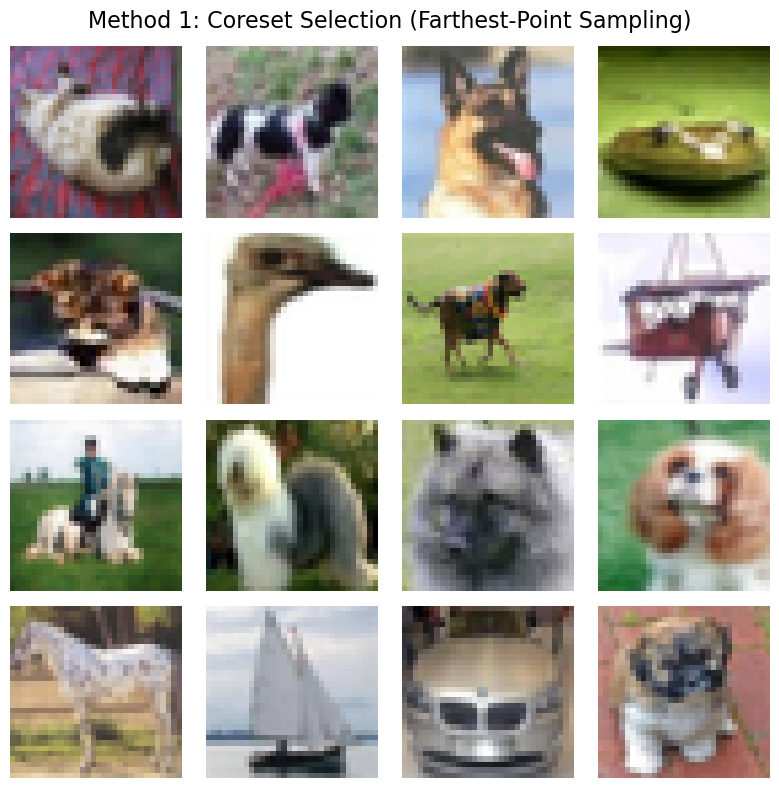

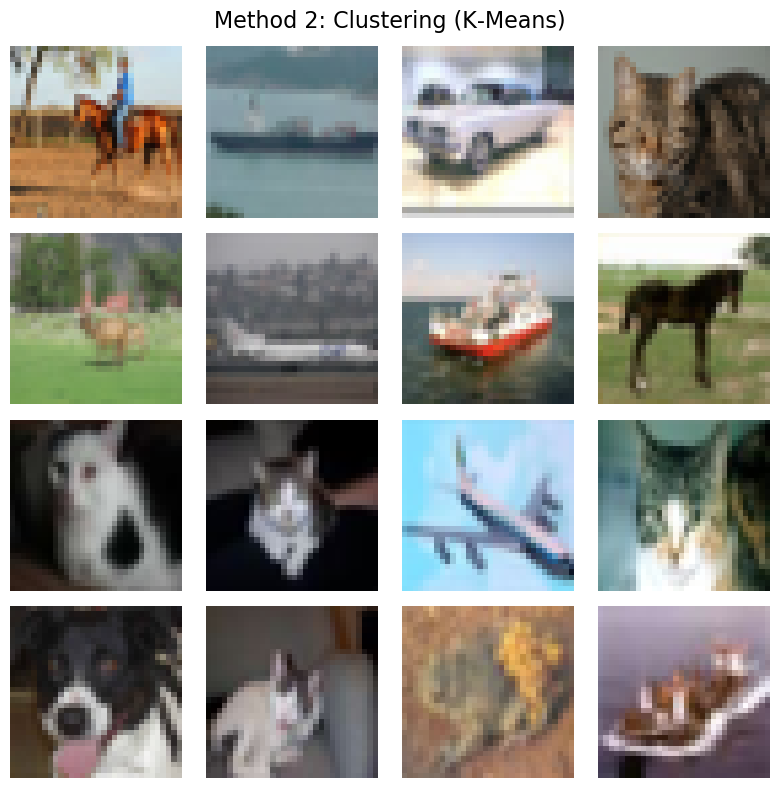

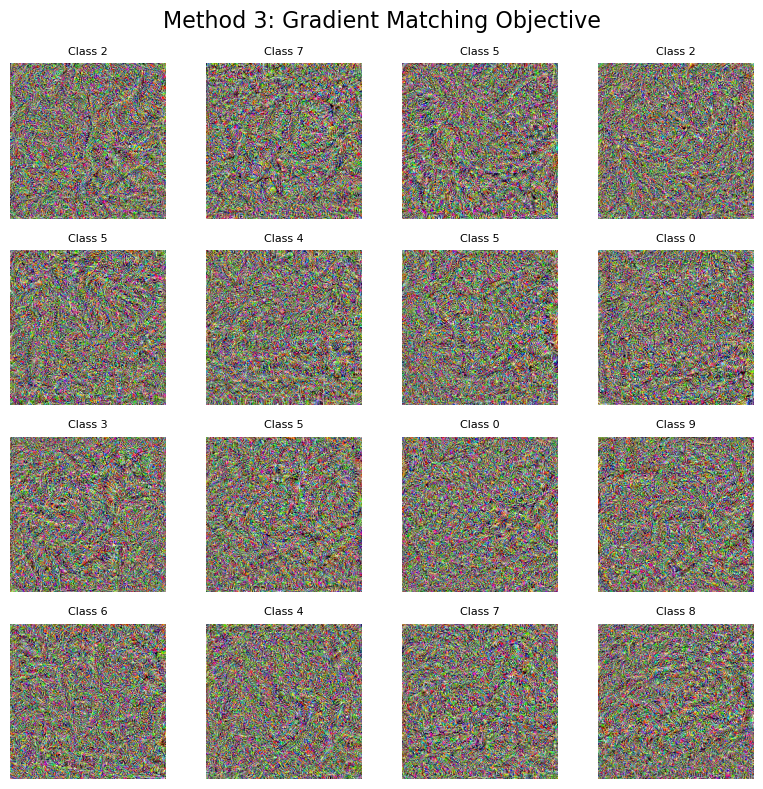

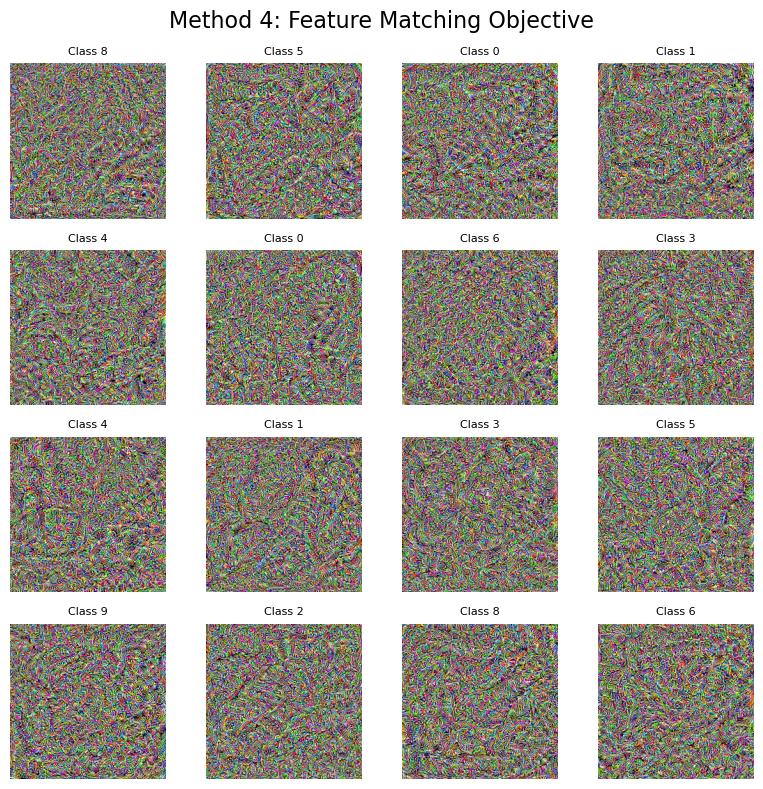

In [7]:
def plot_selected_samples(indices, title, num_samples=16):
    """
    Plot a grid of images given selected indices from the real dataset.
    """
    indices = np.random.choice(indices, num_samples, replace=False)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    for ax, idx in zip(axes.flatten(), indices):
        img, _ = train_dataset_vis[idx]
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualization for Methods 1 & 2 (real images).
plot_selected_samples(coreset_indices, "Method 1: Coreset Selection (Farthest‑Point Sampling)")
plot_selected_samples(cluster_indices, "Method 2: Clustering (K‑Means)")

# Function to unnormalize images (assumes ImageNet normalization).
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return img_tensor

# Function to plot synthetic images.
def plot_synthetic_samples(syn_imgs, syn_labels, title, num_samples=16):
    indices = np.random.choice(len(syn_imgs), num_samples, replace=False)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    for ax, idx in zip(axes.flatten(), indices):
        img = syn_imgs[idx]
        img_np = img.permute(1, 2, 0).numpy()
        label = syn_labels[idx].item()
        ax.imshow(img_np)
        ax.set_title(f"Class {label}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualization for Method 3 (Gradient Matching).
syn_imgs_vis = synthetic_images.detach().cpu()
syn_imgs_vis = unnormalize(syn_imgs_vis)
plot_synthetic_samples(syn_imgs_vis, synthetic_labels.cpu(), "Method 3: Gradient Matching Objective")

# Visualization for Method 4 (Feature Matching).
syn_imgs_fm_vis = synthetic_images_fm.detach().cpu()
syn_imgs_fm_vis = unnormalize(syn_imgs_fm_vis)
plot_synthetic_samples(syn_imgs_fm_vis, synthetic_labels_fm.cpu(), "Method 4: Feature Matching Objective")

# Evaluate methods

In [8]:
###########################
# 1. Create Evaluation Set
###########################

# For training and evaluation we use the same transform as before.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 training set.
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# Load CIFAR-10 test set.
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
########################################
# 2. Create DataLoaders for Each Method
########################################

# Method 1: Coreset Selection – use the indices from coreset_indices.
train_subset_coreset = Subset(train_dataset_full, coreset_indices)
train_loader_coreset = torch.utils.data.DataLoader(train_subset_coreset, batch_size=32, shuffle=True, num_workers=0)

# Method 2: Clustering (K-Means) – use the indices from cluster_indices.
train_subset_cluster = Subset(train_dataset_full, cluster_indices)
train_loader_cluster = torch.utils.data.DataLoader(train_subset_cluster, batch_size=32, shuffle=True, num_workers=0)

# For synthetic datasets (Methods 3 & 4) we create a custom Dataset that does NOT move data off device.
class SyntheticDataset(Dataset):
    def __init__(self, images, labels):
        # images and labels are assumed to already be on 'device'
        self.images = images
        self.labels = labels
    def __len__(self):
        return self.images.size(0)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Method 3: Gradient Matching Synthetic Dataset.
# Do not call .cpu() so that the synthetic images remain on device.
syn_dataset_grad = SyntheticDataset(synthetic_images, synthetic_labels)
# Use num_workers=0 to avoid multiprocessing issues with GPU tensors.
train_loader_grad = torch.utils.data.DataLoader(syn_dataset_grad, batch_size=16, shuffle=True, num_workers=0)

# Method 4: Feature Matching Synthetic Dataset.
syn_dataset_fm = SyntheticDataset(synthetic_images_fm, synthetic_labels_fm)
train_loader_fm = torch.utils.data.DataLoader(syn_dataset_fm, batch_size=16, shuffle=True, num_workers=0)

In [10]:
###########################################
# 3. Define a Training & Evaluation Routine
###########################################

def train_and_evaluate(train_loader, test_loader, epochs=10, lr=1.e-3):
    # Create a fresh ResNet-18 model.
    model = models.resnet18(pretrained=False)
    # Modify final fully-connected layer for 10 classes.
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop.
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, labels in train_loader:
            # Ensure images and labels are on the device.
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    # Evaluation on the test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [11]:
###########################################
# 4. Train a ResNet Model for Each Method
###########################################

results = {}

print("\nTraining on dataset from Method 1: Coreset Selection")
acc_coreset = train_and_evaluate(train_loader_coreset, test_loader, epochs=10, lr=1.e-4)
results["Coreset Selection"] = acc_coreset

print("\nTraining on dataset from Method 2: Clustering (K-Means)")
acc_cluster = train_and_evaluate(train_loader_cluster, test_loader, epochs=10, lr=1.e-4)
results["Clustering (K-Means)"] = acc_cluster

print("\nTraining on dataset from Method 3: Gradient Matching")
acc_grad = train_and_evaluate(train_loader_grad, test_loader, epochs=10, lr=1.e-4)
results["Gradient Matching"] = acc_grad

print("\nTraining on dataset from Method 4: Feature Matching")
acc_fm = train_and_evaluate(train_loader_fm, test_loader, epochs=10, lr=1.e-4)
results["Feature Matching"] = acc_fm


Training on dataset from Method 1: Coreset Selection


/opt/homebrew/Caskroom/miniconda/base/envs/python3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/python3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2797
Epoch 2/10, Loss: 1.8250
Epoch 3/10, Loss: 1.5793
Epoch 4/10, Loss: 1.3709
Epoch 5/10, Loss: 1.1442
Epoch 6/10, Loss: 0.9371
Epoch 7/10, Loss: 0.6951
Epoch 8/10, Loss: 0.4915
Epoch 9/10, Loss: 0.3361
Epoch 10/10, Loss: 0.2650

Training on dataset from Method 2: Clustering (K-Means)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1724
Epoch 2/10, Loss: 1.7130
Epoch 3/10, Loss: 1.3871
Epoch 4/10, Loss: 1.1928
Epoch 5/10, Loss: 0.9946
Epoch 6/10, Loss: 0.7852
Epoch 7/10, Loss: 0.6431
Epoch 8/10, Loss: 0.4424
Epoch 9/10, Loss: 0.2971
Epoch 10/10, Loss: 0.2483

Training on dataset from Method 3: Gradient Matching


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3867
Epoch 2/10, Loss: 1.4189
Epoch 3/10, Loss: 0.8352
Epoch 4/10, Loss: 0.3926
Epoch 5/10, Loss: 0.1768
Epoch 6/10, Loss: 0.0923
Epoch 7/10, Loss: 0.0543
Epoch 8/10, Loss: 0.0294
Epoch 9/10, Loss: 0.0250
Epoch 10/10, Loss: 0.0263

Training on dataset from Method 4: Feature Matching


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3847
Epoch 2/10, Loss: 1.4560
Epoch 3/10, Loss: 0.8514
Epoch 4/10, Loss: 0.4457
Epoch 5/10, Loss: 0.1902
Epoch 6/10, Loss: 0.0908
Epoch 7/10, Loss: 0.0493
Epoch 8/10, Loss: 0.0352
Epoch 9/10, Loss: 0.0228
Epoch 10/10, Loss: 0.0183


In [12]:
###########################################
# 5. Present the Results in a Table
###########################################

print("\nFinal Evaluation Results on CIFAR-10 Test Set:")
print("------------------------------------------------")
print(f"{'Method':30s} | {'Test Accuracy':>12s}")
print("------------------------------------------------")
for method, acc in results.items():
    print(f"{method:30s} | {acc*100:12.2f}%")


Final Evaluation Results on CIFAR-10 Test Set:
------------------------------------------------
Method                         | Test Accuracy
------------------------------------------------
Coreset Selection              |        18.68%
Clustering (K-Means)           |        31.35%
Gradient Matching              |         9.00%
Feature Matching               |        14.29%
